In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import os

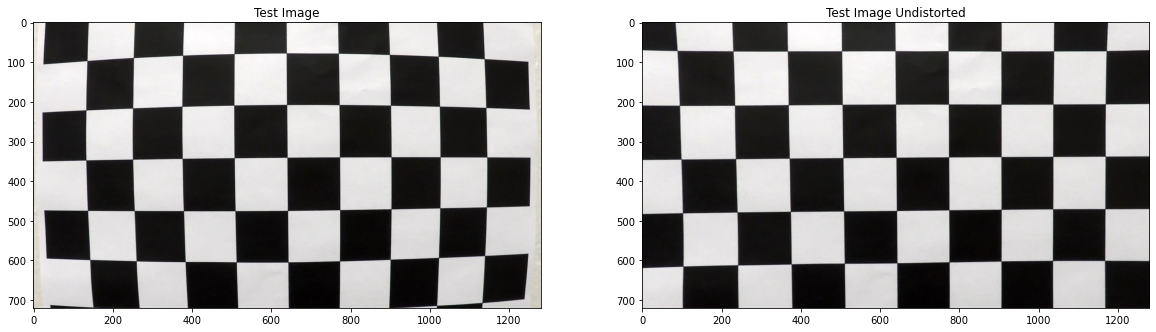

In [2]:
############### Camera calibration  ##################

# Path description for calibration images
path = os.getcwd()
cal_img_path = os.path.join(path,'camera_cal/')

# Cheesboard parameters
num_cornerx = 9
num_cornery = 6

# Object point array preparation
objp = np.zeros((num_cornery*num_cornerx,3), np.float32)
objp[:,:2] = np.mgrid[0:num_cornerx, 0:num_cornery].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# List of calibration images
images = glob.glob(cal_img_path + 'calibration*.jpg')

# Cache containing camera calibration parameter initialization
cache_cam_cal = {}

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = mpimg.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    # Grayscale conversion (RGB2GRAY because I am using matplotlib.image.imread)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (num_cornerx,num_cornery), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Camera calibration cache populated
cache_cam_cal["mtx"] = mtx
cache_cam_cal["dist"] = dist

# Undistortion function definition
def undistortion(img):
    
    dst = cv2.undistort(img, cache_cam_cal["mtx"], cache_cam_cal["dist"], None, cache_cam_cal["mtx"])
    
    return dst

# Sanity check for camera calibration
test_img = mpimg.imread(cal_img_path + 'calibration1.jpg')
test_dst = undistortion(test_img)

# Plot source (distorted) image and undistorted image as comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Test Image')
ax1.imshow(test_img)
ax2.set_title('Test Image Undistorted')
ax2.imshow(test_dst)

In [5]:
## Thresholding & Combination ##

def abs_sobel_threshold(img, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate directional gradient
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    
    grad_binary = np.zeros_like(scaled_sobel)
    
    grad_binary[(scaled_sobel >= min_th) & (scaled_sobel <= max_th)] = 1
    
    return grad_binary

def mag_threshold(image, sobel_kernel = 3, thresh = (0, 255)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate gradient magnitude
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    
    # Apply threshold
    
    mag_binary = np.zeros_like(scaled_sobel)
    
    mag_binary[(scaled_sobel >= min_th) & (scaled_sobel <= max_th)] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel = 3, thresh = (0, np.pi/2)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate gradient direction
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    
    dir_binary = np.zeros_like(grad_dir)
    
    dir_binary[(grad_dir >= min_th) & (grad_dir <= max_th)] = 1
    
    return dir_binary

def hls_threshold(image, hls_channel = 's', thresh = (0, 255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    if hls_channel == 'h':
        channel = h_channel
        print('Chosen h_channel')
    elif hls_channel == 'l':
        channel = l_channel
        print('Chosen l_channel')
    elif hls_channel == 's':
        channel = s_channel
        print('Chosen s_channel')
    
    hlsbinary = np.zeros_like(channel)
    hlsbinary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return hlsbinary

def combine(results):
    
    # results = [[gradx], [grady], [mag_binary], [dir_binary], [hls]]
    
    if len(results) == 1:
        
        combined = results[0]
    
    elif len(results) == 2:
        
        combined = np.zeros_like(results[0])
        combined[((results[0] == 1) & (results[1] == 1))] = 1
    
    elif len(results) == 4:
        
        combined = np.zeros_like(results[0])
        combined[((results[0] == 1) & (results[1] == 1)) | ((results[2] == 1) & (results[3] == 1))] = 1
    
    return combined


def threshold(image, algorithm, sx_ksize = 3, sx_thresh = (30, 100), 
           sy_ksize = 3, sy_thresh = (30, 100), 
           mag_ksize = 3, mag_thresh = (30, 100), 
           dir_ksize = 3, dir_thresh = (0.7, 1.3), 
           channel = 's', hls_thresh = (170, 255)):
    # sx Sobelx gradient, sy Sobely gradient, m Magnitude, d Direction Gradient

    results = []
    combination = []

    for i in range(len(algorithm)):

        if algorithm[i] == 'gradx':
            gradx = abs_sobel_threshold(image, orient = 'x', sobel_kernel = sx_ksize, thresh = sx_thresh)
            results.append(gradx)
            combination.append('gradx')
        elif algorithm[i] == 'grady':
            grady = abs_sobel_threshold(image, orient = 'y', sobel_kernel = sy_ksize, thresh = sy_thresh)
            results.append(grady)
            combination.append('grady')
        elif algorithm[i] == 'mag':
            mag_binary = mag_threshold(image, sobel_kernel = mag_ksize, thresh = mag_thresh)
            results.append(mag_binary)
            combination.append('mag')
        elif algorithm[i] == 'dir':
            dir_binary = dir_threshold(image, sobel_kernel = dir_ksize, thresh = dir_thresh)
            results.append(dir_binary)
            combination.append('dir')
        elif algorithm[i] == 'hls':
            hls_binary = hls_threshold(image, hls_channel = channel, thresh = hls_thresh)
            results.append(hls_binary)
            combination.append('hls ' + channel + '-channel')

        combined = combine(results)
    
    return combined, combination

def warping(image):
    
    vertices = [[150, image.shape[0]],
            [image.shape[1]/2-70,image.shape[0]/2+100],
            [image.shape[1]/2+75,image.shape[0]/2+100],
            [image.shape[1]-120,image.shape[0]]]

    src = np.float32(vertices)
    
    # vertices + lines ploted for visualization

    #cv2.line(image, (int(vertices[0][0]), int(vertices[0][1])), 
    #                 (int(vertices[1][0]), int(vertices[1][1])), color=[255, 0, 0], thickness = 2)
    #
    #cv2.line(image, (int(vertices[1][0]), int(vertices[1][1])), 
    #                 (int(vertices[2][0]), int(vertices[2][1])), color=[255, 0, 0], thickness = 2)
    #
    #cv2.line(image, (int(vertices[2][0]), int(vertices[2][1])), 
    #                 (int(vertices[3][0]), int(vertices[3][1])), color=[255, 0, 0], thickness = 2)

    dst = np.float32([[150, image.shape[0]],
            [150,0],
            [image.shape[1]-150,0],
            [image.shape[1]-150,image.shape[0]]])
    
    img_size = (image.shape[1], image.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    # y is [0] because y is vertical - rows, x is horizontal [1] - columns
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        # start from bottom line - binary_warped.shape[0] = ymax
        # since first value of window is 0, 0*window_height = 0, win_y_high = ymax
        # win_y_low = ymax-1*window_height
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    ym_per_pix = 30/720   # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meters per pixel in x dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, deg = 2)
    right_fit = np.polyfit(righty, rightx, deg = 2)
    
    #left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg = 2)
    #right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg = 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    #return out_img, ploty*ym_per_pix, left_fit, right_fit

    return out_img, ploty, left_fit, right_fit

def measure_curvature_pixels(image):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    _, ploty, left_fit, right_fit = fit_polynomial(image)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2)/(np.absolute(2*left_fit[0]))  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2)/(np.absolute(2*right_fit[0]))  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

12101.845618452708
15650.44308674591


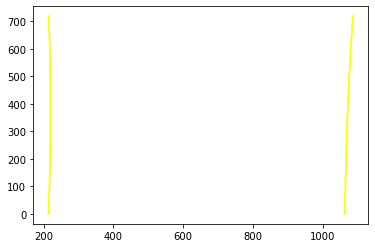

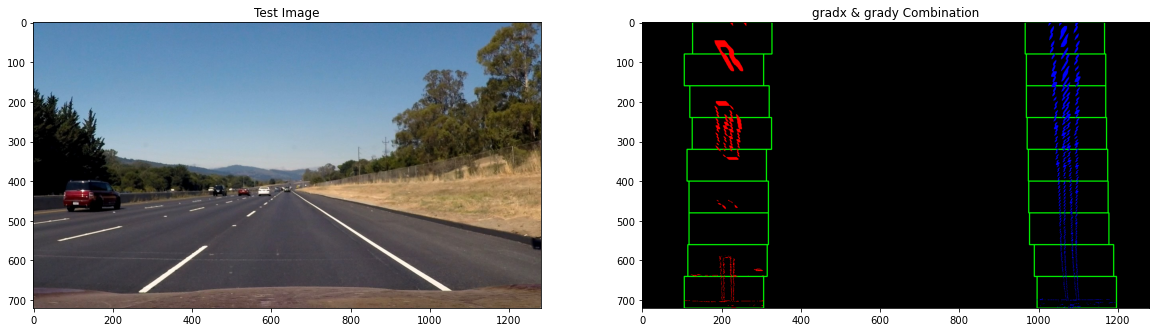

In [6]:
############### Pipeline test image ################## 

# Path description for test images
path = os.getcwd()
test_img_path = os.path.join(path,'test_images/')

# List of test images
images = os.listdir(test_img_path)
data_paths = [os.path.join(test_img_path, f) for f in images]

#for i in range(len(data_path))
image = mpimg.imread(data_paths[6])

img_size = (image.shape[1], image.shape[0])

########## Thresholding ###########

algorithm = ['gradx', 'grady']
ksize = 3

combined, combination = threshold(image, algorithm, sx_thresh = (2, 100), channel = 's', hls_thresh = (170, 255))

###### Perspective Transform ######

warped = warping(combined)

########### Find Lines ############
######### Histogram Peaks #########
######### Sliding Windows #########

out_img, _, _, _ = fit_polynomial(warped)

left_curverad, right_curverad = measure_curvature_pixels(warped)

print(left_curverad)
print(right_curverad)

# Visualizing

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Test Image')
ax1.imshow(image)

if len(combination) > 1:
    ax2.set_title(combination[0] + ' & ' + combination[1] + ' Combination')
    
else:
    ax2.set_title(combination[0])

ax2.imshow(out_img)

# Save converted images in folder "output_images"
#file_name = path + 'output_images/' + str(images[im])
#cv2.imwrite(file_name, lines_edges)

In [ ]:

########### Find Lines ############

######### Histogram Peaks #########

######### Sliding Windows #########

######## Search from Prior ########

# Curvature Radius (pixel/real world)




In [ ]:
#def generate_data():
#    '''
#    Generates fake data to use for calculating lane curvature.
#    In your own project, you'll ignore this function and instead
#    feed in the output of your lane detection algorithm to
#    the lane curvature calculation.
#    '''
#    # Set random seed number so results are consistent for grader
#    # Comment this out if you'd like to see results on different random data!
#    np.random.seed(0)
#    # Generate some fake data to represent lane-line pixels
#    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
#    # For each y position generate random x position within +/-50 pix
#    # of the line base position in each case (x=200 for left, and x=900 for right)
#    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                    for y in ploty])
#    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                    for y in ploty])
#
#    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
#
#
#    # Fit a second order polynomial to pixel positions in each fake lane line
#    left_fit = np.polyfit(ploty, leftx, 2)
#    right_fit = np.polyfit(ploty, rightx, 2)
#    
#    return ploty, left_fit, right_fit